# Heat equation with NGD
Consider the following PDE on $\Omega=[0,1]^2$:
$$
\begin{cases}
\frac{\partial}{\partial t}u(t,x,y)-D \Delta u(t,x,y) = 0,\\
u(0, x, y)=\sin\pi x\sin\pi y
\end{cases}
$$

The solution is (TO CHECK) $u^\star(t,x) = e^{-2D\pi^2 t}\sin\pi x\sin\pi y$

In [1]:
import jinns

import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

/home/nicolas/Recherche/INRAE/PINN/jinns/jinns/loss/_LossODE.py:41: UserWarning: Class `jinns.loss._LossODE.LossODE` has both an `__init__` method and a `__post_init__` method. This means that the `__post_init__` method will not be run!
The reason for this is that `__post_init__` is intended to be used with the automatically-generated `__init__` method provided by Python dataclasses, which are generated of the form:
```
def __init__(self, field1, field2)
    self.field1 = field1
    self.field2 = field2
    self.__post_init__()
```
and as such a user-provided `__init__` overrides both the setting of fields, and the calling of `__post_init__`.
The above is how Python dataclasses work, and has nothing to do with Equinox!
If you are using `__post_init__` to check that certain invariants hold, then consider using `__check_init__` instead. This is an Equinox-specific extension that is always ran. See here for more details: https://docs.kidger.site/equinox/api/module/advanced_fields/#checkin

In [2]:
n = 200
ni = n
nb = n
domain_batch_size = n
initial_batch_size = ni
border_batch_size = nb // 4
dim = 2
xmin = -1
xmax = 1
tmin = 0
tmax = 1
Tmax = 1
method = "uniform"

train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    ni=ni,
    domain_batch_size=domain_batch_size,
    border_batch_size=border_batch_size,
    initial_batch_size=initial_batch_size,
    dim=dim,
    min_pts=(xmin, xmin),
    max_pts=(xmax, xmax),
    tmin=tmin,
    tmax=tmax,
    method=method,
)

In [3]:
eqx_list = (
    (eqx.nn.Linear, 3, 25),  # 3 = t + x (2D)
    (jax.nn.tanh,),
    (eqx.nn.Linear, 25, 25),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 25, 1),
)

key, subkey = random.split(key)
u, init_sol_nn_params = jinns.nn.PINN_MLP.create(
    key=subkey, eqx_list=eqx_list, eq_type="PDENonStatio"
)

In [4]:
D = jnp.array(0.2)
init_params = jinns.parameters.Params(
    nn_params=init_sol_nn_params,
    eq_params={"D": D},
)

In [5]:
from jinns.loss import PDENonStatio


class HeatEquation(PDENonStatio):
    def equation(self, t_x, u, params):
        u_t_x = lambda t_x: u(t_x, params).squeeze()
        u_dt = jax.grad(u_t_x)(t_x)[0:1]
        lap = jinns.loss.laplacian_rev(t_x, u, params, eq_type="PDENonStatio")
        return u_dt - params.eq_params.D * lap


dyn_loss_heat = HeatEquation()

In [6]:
loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=jnp.array(1.0),
    initial_condition=jnp.array(1.0),
    boundary_loss=jnp.array(1.0),
)

In [7]:
def u0(x):
    # mu_0 = jnp.zeros((dim,))
    # cov_0 = 0.3 * jnp.eye(dim)
    # return jax.scipy.stats.multivariate_normal.pdf(x, mean=mu_0, cov=cov_0)
    return jnp.sin(jnp.pi * x[0]) * jnp.sin(jnp.pi * x[1])

In [8]:
u0(jnp.ones(2))

Array(7.642742e-15, dtype=float32)

In [9]:
loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=dyn_loss_heat,
    initial_condition_fun=u0,
    boundary_condition=jinns.loss.Dirichlet(),
    params=init_params,
)

In [10]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
key, subkey = random.split(key)
train_data, colloc_batch = train_data.get_batch()

std_grad = losses_and_grad(init_params, batch=colloc_batch)[1]

In [11]:
r, g = loss.evaluate_natural_gradient(
    init_params,
    colloc_batch,
    non_opt_params=None,
    ret_nat_grad_terms=True,
)

In [12]:
r

PDENonStatioComponents(
  dyn_loss=f32[200,1],
  norm_loss=None,
  boundary_loss=(f32[50,1], f32[50,1], f32[50,1], f32[50,1]),
  observations=None,
  initial_condition=f32[200,1]
)

In [13]:
l = jax.tree.map(
    lambda pt: jax.tree.leaves(pt.nn_params, is_leaf=lambda x: eqx.is_inexact_array(x)),
    g,
    is_leaf=lambda x: isinstance(x, jinns.parameters.Params),
)

In [14]:
r_temp = jax.tree.map(lambda leaf: [leaf], r)

In [15]:
r_temp

PDENonStatioComponents(
  dyn_loss=[f32[200,1]],
  norm_loss=None,
  boundary_loss=([f32[50,1]], [f32[50,1]], [f32[50,1]], [f32[50,1]]),
  observations=None,
  initial_condition=[f32[200,1]]
)

In [16]:
def post_process_pytree_of_grad(y):
    l = jax.tree.map(
        lambda pt: jax.tree.leaves(
            pt.nn_params, is_leaf=lambda x: eqx.is_inexact_array(x)
        ),
        y,
        is_leaf=lambda x: isinstance(x, jinns.parameters.Params),
    )

    l2 = jax.tree.map(
        lambda l1, l2: [a.reshape((a.shape[0], -1)) for a in l1],
        l,
        r_temp,
        is_leaf=lambda x: isinstance(x, list),
    )

    l3 = jax.tree.map(
        lambda leaf: jnp.concatenate(leaf, axis=1),
        l2,
        is_leaf=lambda x: isinstance(x, list),
    )

    return jnp.concatenate(jax.tree.leaves(l3), axis=0)

In [17]:
M = post_process_pytree_of_grad(g)

In [18]:
# Do the same sur r
R = jnp.concatenate(jax.tree.leaves(r), axis=0)

In [19]:
print(R.shape, M.shape)

(600, 1) (600, 776)


In [20]:
euclidean_grad = jnp.mean(R * M, axis=0)

In [21]:
l2 = [el.flatten() for el in jax.tree.leaves(std_grad.nn_params)]

In [22]:
std_grad_flatten = (1 / (n + ni)) * jnp.concatenate(l2, axis=0)

In [23]:
jnp.allclose(std_grad_flatten, 2 * euclidean_grad)

Array(False, dtype=bool)

In [24]:
# Assemble Gram Matrix
# gram_mat = jnp.mean(jax.vmap(lambda u, v: jnp.outer(u, v), (0, 0))(M, M), axis=0)
gram_mat = jnp.mean(M[..., None] @ M[:, None, :], axis=0)

In [25]:
reg = 1e-5
n_param = gram_mat.shape[0]
natural_grad = jax.scipy.linalg.solve(
    gram_mat + reg * jnp.eye(n_param), euclidean_grad, assume_a="sym"
)

In [26]:
params_cumsum = jinns.nn._hyperpinn._get_param_nb(init_params.nn_params)[1]
ng_flat = eqx.tree_at(
    jax.tree.leaves,
    init_params.nn_params,
    jnp.split(natural_grad, params_cumsum[:-1]),
)

ng_pt = jax.tree.map(
    lambda a, b: a.reshape(b.shape),
    ng_flat,
    init_params.nn_params,
    is_leaf=lambda x: isinstance(x, jnp.ndarray),
)

In [27]:
import optax

n_iter = 100
# tx = optax.adam(learning_rate=1e-3)
tx = optax.sgd(learning_rate=1e-3)

In [28]:
params = init_params

In [29]:
key, subkey = random.split(key, 2)
(
    params,
    total_loss_list,
    loss_by_term_dict,
    train_data,
    loss,
    _,
    _,
    _,
    _,
    _,
    _,
    _,
) = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
    print_loss_every=n_iter // 10,
)

Initialization time: 0.1193838119506836


ValueError: Cannot broadcast to shape with fewer dimensions: arr_shape=(4,) shape=()

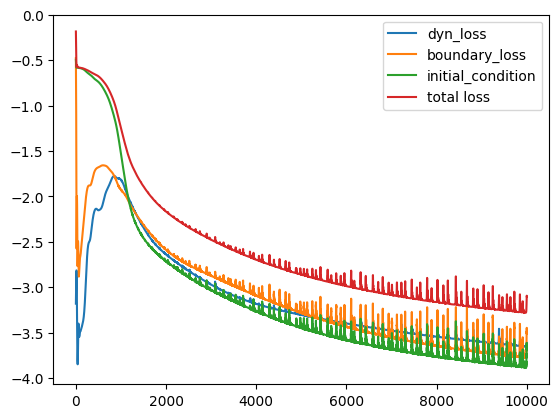

In [ ]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show()

Solution : u(t, x)


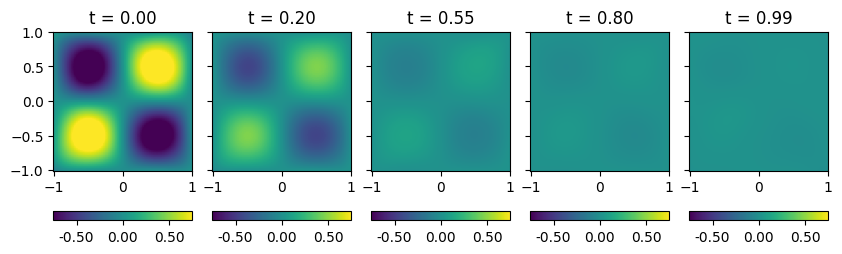

In [ ]:
u_est = lambda t_x: u(t_x, params)[0]
nx = 200
val_xydata = [jnp.linspace(xmin, xmax, nx), jnp.linspace(xmin, xmax, nx)]
times = [0, 0.2, 0.55, 0.8, 0.99]  # times in the rescaled time susescale

jinns.plot.plot2d(
    u_est,
    xy_data=val_xydata,
    times=times,
    cmap="viridis",
    figsize=(10, 10),
    vmin_vmax=(-0.75, 0.75),
)
print("Solution : u(t, x)")

In [ ]:
def u_true(t_x):
    t, x = t_x[0], t_x[1:]
    return jnp.exp(-2 * D * t * jnp.pi**2) * u0(x)


# Sanity check of true u formula
txy = jax.random.uniform(key, shape=(100, 3))
true_res = vmap(dyn_loss_heat.equation, (0, None, None))(
    txy, lambda tx, p: u_true(tx), init_params
)
assert jnp.allclose(true_res, jnp.zeros(100), atol=1e-6)

Ground truth : $u^\star(t, x)$


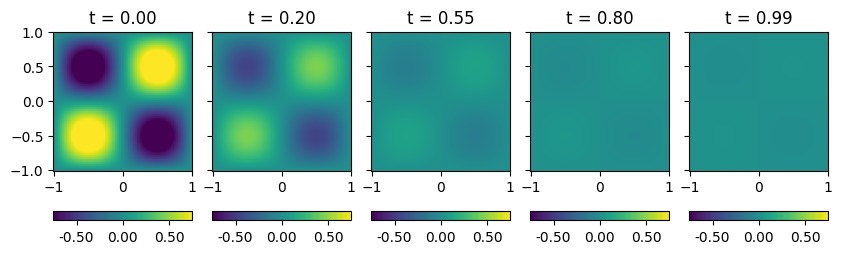

In [ ]:
jinns.plot.plot2d(
    u_true,
    xy_data=val_xydata,
    times=times,
    cmap="viridis",
    figsize=(10, 10),
    vmin_vmax=(-0.75, 0.75),
    title=r"Ground truth : $u^\star(t, x)$",
)
print(r"Ground truth : $u^\star(t, x)$")

Ground truth : $u^\star(t, x)$


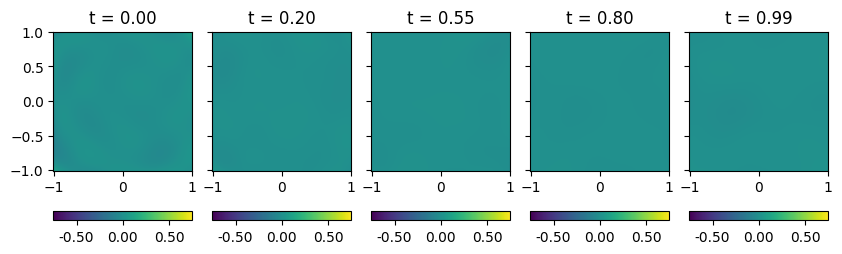

In [ ]:
# Plot difference
jinns.plot.plot2d(
    lambda tx: u_true(tx) - u_est(tx),
    xy_data=val_xydata,
    times=times,
    cmap="viridis",
    figsize=(10, 10),
    vmin_vmax=(-0.75, 0.75),
    title=r"Ground truth : $u^\star(t, x)$",
)
print(r"Ground truth : $u^\star(t, x)$")

# Natural gradient